Test notebook

In [20]:
import numpy as np
import os
import pickle
from scipy.signal import savgol_filter
import matplotlib.pyplot as plt

from qibocal.protocols.two_qubit_interaction.cryoscope import (
    CryoscopeData,
    CryoscopeResults,
)

from cryoscope_scripts import build_phase

POLYORDER = 2
PHASE_SCALING = 2 * np.pi
MODE = "nearest"
os.makedirs(MODE, exist_ok=True)

sigmas = np.arange(0.0, 0.007, 0.0005)
time = np.arange(0, 70, 1)
c = -np.pi / 8
start = 10


def generate_phases():
    sigmas = np.arange(0.007, 0.01, 0.0005)
    time = np.arange(0, 70, 1)
    c = -np.pi / 8
    start = 10

    dtype = [("sigma", "f8"), ("phase", "O")]
    phases = np.array(
        [(sigma, np.array(build_phase(time, c, start, sigma))) for sigma in sigmas],
        dtype=dtype,
    )
    #np.save("phases_data.npy", phases)
    return phases

def compute_detunings(phases):
    window_lengths = np.arange(3, 9, 1)
    detunings_results = []

    for sigma, phase in zip(phases["sigma"], phases["phase"]):
        for length in window_lengths:
            detuning = savgol_filter(
                phase, 
                window_length=length, 
                polyorder=POLYORDER, 
                deriv=1, 
                mode=MODE
            )
            detunings_results.append(
                {"sigma": sigma, "window_length": length, "detuning": detuning}
            )
    #np.save(f"{MODE}/detunings_data.npy", detunings_results)

    return detunings_results

In [21]:
phases = generate_phases()
detunings = compute_detunings(phases)

In [26]:
def plot_detunings_by_sigma(detunings_results):
    # Group data by sigma
    grouped_results = {}
    for entry in detunings_results:
        sigma = entry["sigma"]
        if sigma not in grouped_results:
            grouped_results[sigma] = []
        grouped_results[sigma].append(entry)

    # Extract unique window lengths and create a colormap
    unique_lengths = np.unique([entry["window_length"] for entry in detunings_results])
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_lengths)))
    length_color_map = {length: color for length, color in zip(unique_lengths, colors)}

    # Create plots for each sigma
    for sigma, entries in grouped_results.items():
        plt.figure(figsize=(12, 6))
        for entry in entries:
            window_length = entry["window_length"]
            detuning = entry["detuning"]
            color = length_color_map[
                window_length
            ]  # Assign color based on window length
            plt.plot(detuning, label=f"Window Length: {window_length}", color=color)

        plt.title(f"Detunings for Sigma: {sigma}")
        plt.xlabel("Index")
        plt.ylabel("Detuning")
        plt.legend(title="Window Length")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

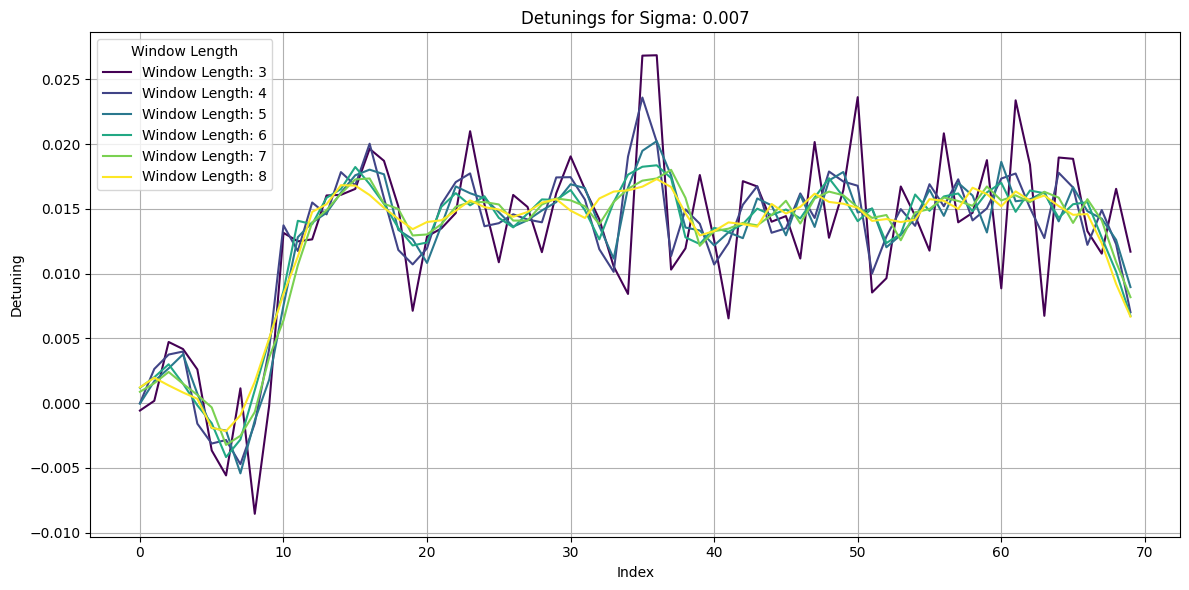

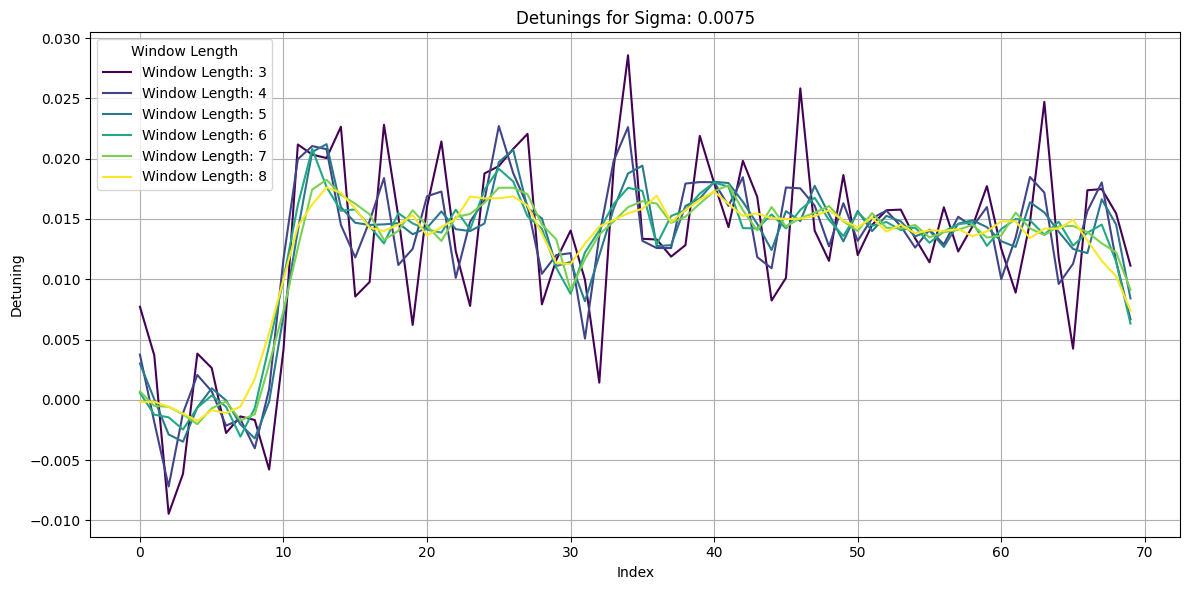

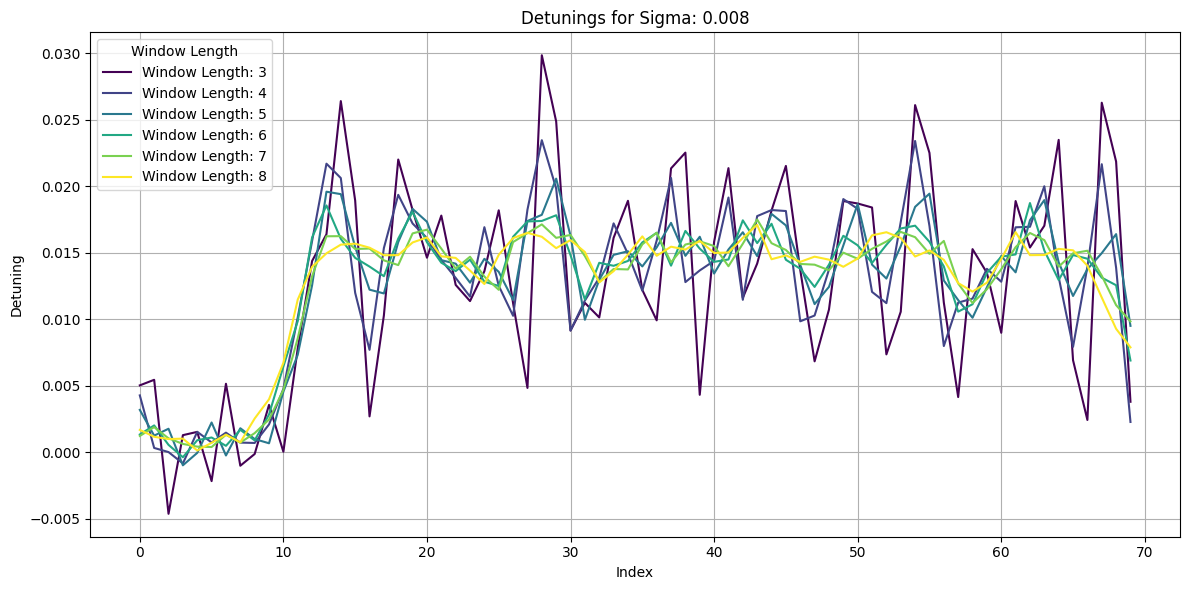

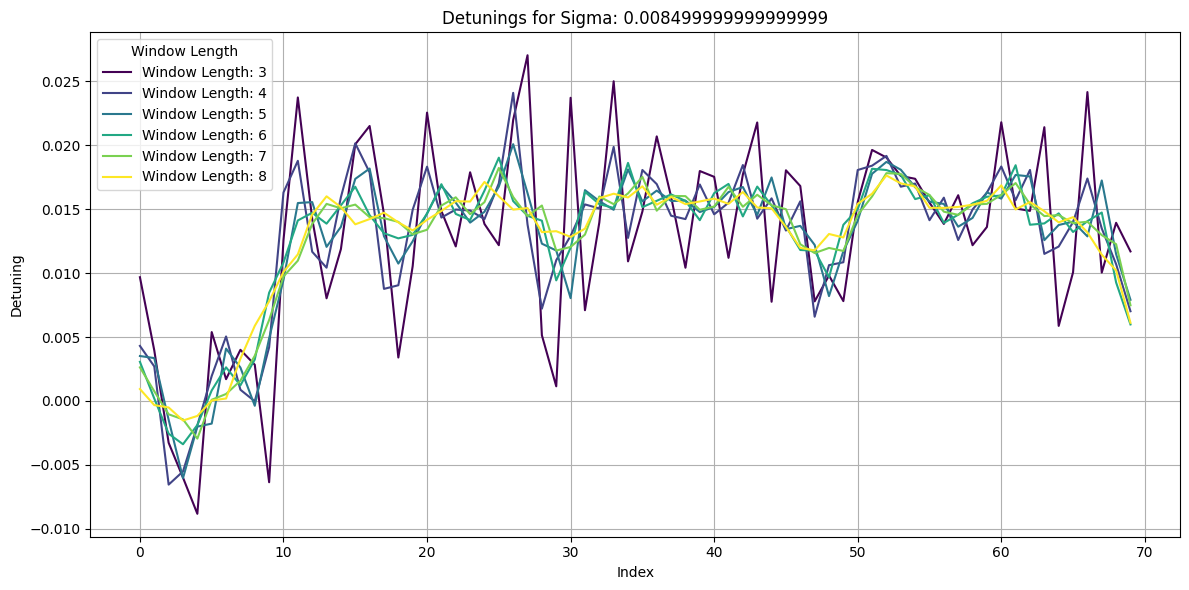

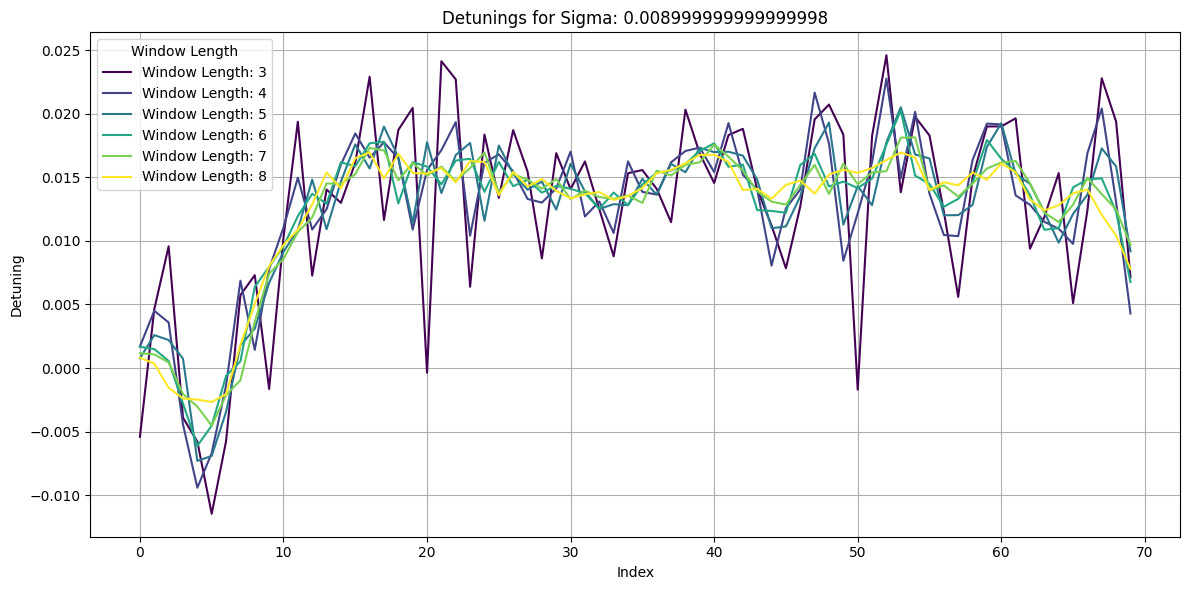

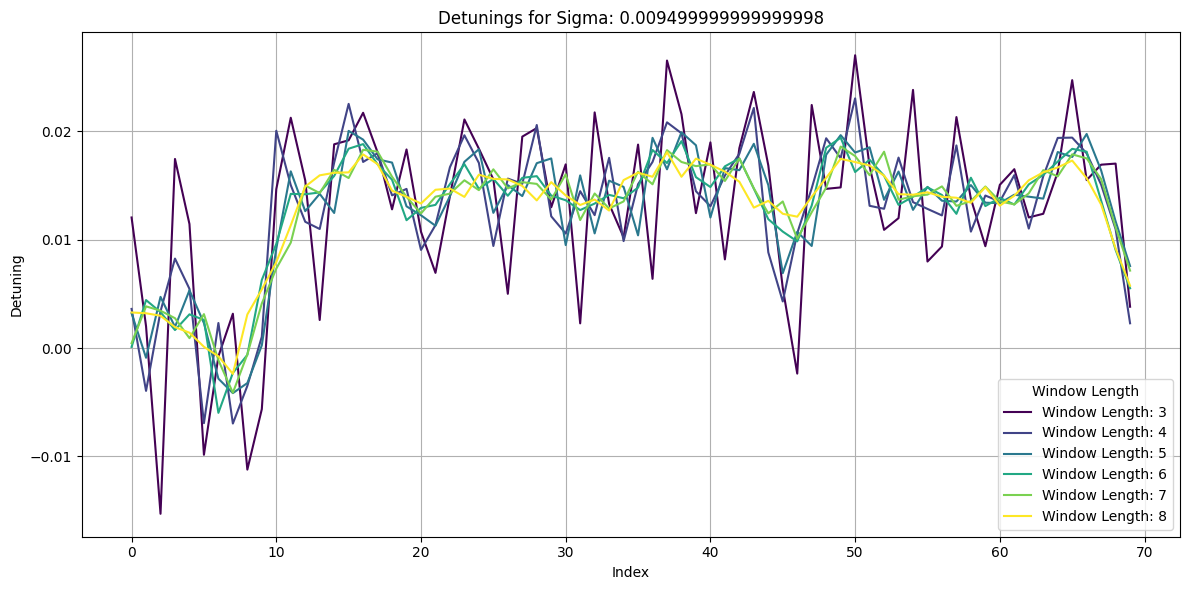

In [28]:
plot_detunings_by_sigma(detunings)